In [2]:
#imports
import sys
import subprocess 
import importlib

import time

import numpy as np

import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

from numba import njit

#Nice plots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticks
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 5.1
fontsize = 10
plt.rcParams.update({
    'text.usetex'        : True,
    'font.family'        : 'sans-serif',
    'font.size'          : fontsize,
    'text.latex.preamble': r'\usepackage{libertine}'
})
#plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
import re
from pylatexenc.latexencode import UnicodeToLatexEncoder, \
 UnicodeToLatexConversionRule, RULE_REGEX
u2latex = UnicodeToLatexEncoder(
    conversion_rules=[
        UnicodeToLatexConversionRule(rule_type=RULE_REGEX, rule=[
            (re.compile(r'𝜈'), r'\\ensuremath{\\nu}'),
            (re.compile(r'𝛾'), r'\\ensuremath{\\gamma}'),
            (re.compile(r'⁻'), r'\\ensuremath{^-}'),
            (re.compile(r'⁺'), r'\\ensuremath{^+}'),
        ]),
        'defaults'
    ]
)
#class for adding units to axis
class AddK(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' K'
        return s


#Reaction networks
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
import np_AoT_net as bbn_np
import AoT_net as bbn_Li
import full_AoT_net as bbn_full

networks=[bbn_np,bbn_Li,bbn_full]

#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc() for net in networks]+[2]

In [3]:
#Unit conversions
timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV

#constants
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015


#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

In [4]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
        for i in range(len(Y),n):
            tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    #if y[0]<0.1
    #    return 
    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(PNAsort(Yj))

In [5]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,20)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,20)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,20)])  

### Initial conditions ###

T_ini=10                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini           #initial baryon density

def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3


### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)

t_range=[t_ini,2e5*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,100000))#,t_eval=t_space)

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2
solt=sol.t

@njit
def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt,Tsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

#fig.savefig('TeX/figures/Temperature.pdf')

In [6]:
T_cache(60*timeunit)

0.13301814956652525

In [7]:
tLi=3/(2*np.sqrt(43/5*G*np.pi**3))/(20/TMeV2T9 )**2
#tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2

testtimes=np.geomspace(10,10000,100)
#testtimes=np.geomspace(10,40,2)*timeunit
abuns=[]
solYs=[]
soltimes=[]
for tfull in testtimes*timeunit:

    #times for switching between networks
    t_start=[t_ini,tLi,tfull,1e5*timeunit]

    #Solve the system
    #initial conditions

    solY=np.array([[1/(np.exp(Q/T_ini)+1)],[1/(np.exp(-Q/T_ini)+1)]])
    soltime=np.array([t_ini])

    for i in range(len(networks)):

        if t_start[i]<3*timeunit:
            initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
        else:
            initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)


        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    
    abuns.append(abun)
    #solYs.append(solY)
    #soltimes.append(soltime)
    print(jacsolY)




  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 56709
     njev: 3589
      nlu: 7498
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.24450576e-09, 1.01689563e-07, ...,
       1.51197559e+26, 1.51679233e+26, 1.51884810e+26])
 t_events: None
        y: array([[1.70065815e-001, 1.70065815e-001, 1.70065815e-001, ...,
        8.40171741e-012, 8.31359931e-012, 8.27634697e-012],
       [8.29934185e-001, 8.29934185e-001, 8.29934185e-001, ...,
        7.52900036e-001, 7.52900036e-001, 7.52900036e-001],
       [1.98889366e-011, 1.98889366e-011, 1.98889366e-011, ...,
        1.90660908e-005, 1.90660791e-005, 1.90660741e-005],
       ...,
       [0.00000000e+000, 4.44825717e-130, 5.38239117e-128, ...,
        1.25041879e-047, 1.18699259e-047, 1.16096251e-047],
       [0.00000000e+000, 3.45464888e-141, 4.18012514e-139, ...,
        1.75527483e-034, 1.70876558e-034, 1.68933045e-034],
       [0.00000000e+000, 1.13785212e-1

In [8]:
abuns[0][2]

1.9066074109888382e-05

In [9]:
testtimes

array([   10.        ,    10.72267222,    11.49756995,    12.32846739,
          13.21941148,    14.17474163,    15.19911083,    16.29750835,
          17.475284  ,    18.73817423,    20.09233003,    21.5443469 ,
          23.101297  ,    24.77076356,    26.56087783,    28.48035868,
          30.53855509,    32.74549163,    35.11191734,    37.64935807,
          40.37017259,    43.28761281,    46.41588834,    49.77023564,
          53.36699231,    57.22367659,    61.35907273,    65.79332247,
          70.54802311,    75.64633276,    81.11308308,    86.97490026,
          93.26033469,   100.        ,   107.2267222 ,   114.97569954,
         123.28467394,   132.19411485,   141.74741629,   151.9911083 ,
         162.97508346,   174.75284   ,   187.38174229,   200.92330026,
         215.443469  ,   231.01297001,   247.7076356 ,   265.60877829,
         284.80358684,   305.38555088,   327.45491629,   351.11917342,
         376.49358068,   403.70172586,   432.87612811,   464.15888336,
      

In [10]:
altY_labels=['n',
 'p',
 'H2',
 'H3',
 'He3',
 'He4',
 'Li6',
 'Li7\&Li8',
 'Li8',
 'Be7',
 'Be9',
 'B8',
 'B10',
 'B11',
 'B12',
 'C11',
 'C12',
 'C13',
 'C14',
 'N12',
 'N13',
 'N14',
 'N15',
 'O14',
 'O15',
 'O16']

'\n\n\n\n'

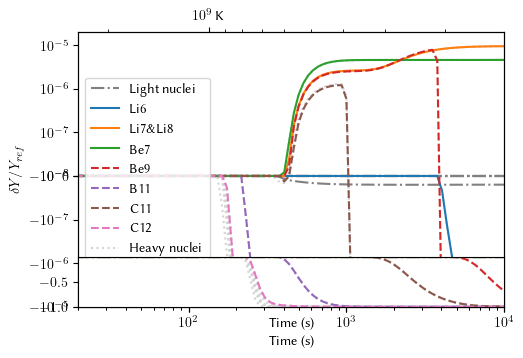

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(width, 3.5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.975, bottom=0.115, top=0.90)
spacing=[1,1,3,3,2,1]

[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]

He4=[abun[5] for abun in abuns]
He3=[(abun[3]+abun[4])for abun in abuns]
H2=[abun[2] for abun in abuns]
Li6=[abun[6] for abun in abuns]
Li7=[abun[7]+abun[9] for abun in abuns]



plt.xlabel('Time (s)')
plt.ylabel(r'$\delta Y/Y_{ref}$')
xlims=(20,10000)
plt.ylim(-1e-5,2e-5)
#plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('symlog',linthresh=1e-8,linscale=1e-5)
#axes.tick_params(bottom=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes.plot(testtimes,[(abun[1]) for abun in abuns],'-.',color='gray', label='Light nuclei')
for i in range(6,fnNucs):
    axes.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],':',color='lightgray')
for i in range(6):
    axes.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],'-.',color='gray')

for i in [6,7,9,10,13,15,16]:
    axes.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],line[i],label=altY_labels[i])

axes.plot(testtimes,[(abun[1]) for abun in abuns],':',color='lightgray', label='Heavy nuclei')

plt.legend(loc='center left')
axes.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

divider = make_axes_locatable(axes)
axLin = divider.append_axes("bottom", size=0.5, pad=0.02, sharex=axes)
#axLin.plot(xdomain, np.sin(xdomain))
axLin.set_ylim((-1, -1e-5))
for i in range(6,fnNucs):
    axLin.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],':',color='lightgray')
for i in range(6):
    axLin.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],'-.',color='gray')

for i in [6,7,9,10,13,15,16]:
    axLin.plot(testtimes,[(abun[i]-abuns[0][i])/abuns[0][i] for abun in abuns],line[i],label=altY_labels[i])
plt.xlim(*xlims)
plt.xlabel('Time (s)')
'''



'''

#plt.title('Linear above, log below')

#fig.savefig('TeX/figures/Bignettime.pdf')


#plt.xlim(0.5,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
#plt.yscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
#plt.xlabel('Number of terms')
#plt.ylabel(r'$\delta Y/Y_{ref}$')
#plt.legend(title='T (MeV)',loc='upper right')
#50keV
#fig.savefig('TeX/figures/Besselaccuracy.pdf')

In [14]:
#tLi=3/(2*np.sqrt(43/5*G*np.pi**3))/(20/TMeV2T9 )**2
#tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2
earlist=3/(2*np.sqrt(43/5*G*np.pi**3))/(3 )**2/timeunit
midtesttimes=np.geomspace(20,40,10)
#testtimes=np.geomspace(10,40,2)*timeunit
midabuns=[]
midsolYs=[]
midsoltimes=[]
for tLi in midtesttimes*timeunit:

    #times for switching between networks
    t_start=[t_ini,tLi,1e2*timeunit,1e5*timeunit]
    print(tLi/timeunit)
    #Solve the system
    #initial conditions

    solY=np.array([[1/(np.exp(Q/T_ini)+1)],[1/(np.exp(-Q/T_ini)+1)]])
    soltime=np.array([t_ini])

    for i in range(len(networks)):

        if t_start[i]<3*timeunit:
            initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
        else:
            initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)


        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    
    midabuns.append(abun)
    #midsolYs.append(solY)
    #midsoltimes.append(soltime)
    print(jacsolY)




20.0
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 39073
     njev: 1444
      nlu: 3282
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 2.34126458e-29, 2.57539104e-28, ...,
       1.50947738e+26, 1.51428706e+26, 1.51748100e+26])
 t_events: None
        y: array([[1.46055962e-001, 1.46055962e-001, 1.46055962e-001, ...,
        8.42258126e-012, 8.33431530e-012, 8.27634697e-012],
       [8.53940475e-001, 8.53940475e-001, 8.53940475e-001, ...,
        7.52900036e-001, 7.52900036e-001, 7.52900036e-001],
       [9.40998010e-007, 9.40998010e-007, 9.40998010e-007, ...,
        1.90660936e-005, 1.90660818e-005, 1.90660741e-005],
       ...,
       [0.00000000e+000, 2.88350436e-149, 3.48904027e-147, ...,
        1.26582440e-047, 1.20166780e-047, 1.16096251e-047],
       [0.00000000e+000, 1.99668756e-176, 2.41599195e-174, ...,
        1.76639769e-034, 1.71963169e-034, 1.68933045e-034],
       [0.00000000e+000, 6.943586

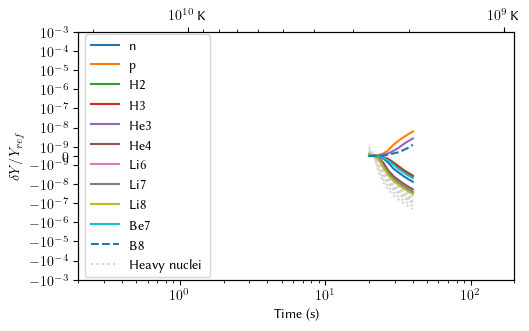

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(width, 3.2))

#fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.995, bottom=0.125, top=0.90)
spacing=[1,1,3,3,2,1]

#plt.plot(midtesttimes,[(abun[1]) for abun in midabuns],'-.',color='gray', label='Light nuclei')
stabilitystep=1
for i in range(10,fnNucs):
    plt.plot(midtesttimes,[(abun[i]-midabuns[stabilitystep][i])/midabuns[stabilitystep][i] for abun in midabuns],':',color='lightgray')

for i in range(10):#,11,12,13,15,16]:
    plt.plot(midtesttimes,[(abun[i]-midabuns[stabilitystep][i])/midabuns[stabilitystep][i] for abun in midabuns],line[i],label=Y_labels[i])
plt.plot(midtesttimes,[(abun[11]-midabuns[stabilitystep][11])/midabuns[stabilitystep][11] for abun in midabuns],line[11],label=Y_labels[11])

plt.plot(midtesttimes,[(abun[1]) for abun in midabuns],':',color='lightgray', label='Heavy nuclei')

plt.xlabel('Time (s)')
plt.ylabel(r'$\delta Y/Y_{ref}$')
xlims=(0.2,200)
plt.ylim(-1e-3,1e-3)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.yscale('symlog',linthresh=1.2e-9,linscale=0.5)

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/midnettime.pdf')
plt.show()

#plt.xlim(0.5,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
#plt.yscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
#plt.xlabel('Number of terms')
#plt.ylabel(r'$\delta Y/Y_{ref}$')
#plt.legend(title='T (MeV)',loc='upper right')
#50keV
#fig.savefig('TeX/figures/Besselaccuracy.pdf')

In [16]:
tLi=3/(2*np.sqrt(43/5*G*np.pi**3))/(20/TMeV2T9 )**2
#tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2

nptesttimes=np.geomspace(t_ini/timeunit,10,100)
#testtimes=np.geomspace(10,40,2)*timeunit
npabuns=[]
npsolYs=[]
npsoltimes=[]
for tnp in nptesttimes*timeunit:

    #times for switching between networks
    t_start=[tnp,30*timeunit,100*timeunit,1e5*timeunit]

    #Solve the system
    #initial conditions

    solY=np.array([[1/(np.exp(Q/T_cache(tnp))+1)],[1/(np.exp(-Q/T_cache(tnp))+1)]])
    soltime=np.array([tnp])

    for i in range(len(networks)):

        initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)


        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    
    npabuns.append(abun)
    #solYs.append(solY)
    #soltimes.append(soltime)
    print(jacsolY)




  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 39093
     njev: 1443
      nlu: 3280
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 2.34958996e-29, 2.58454896e-28, ...,
       1.50966901e+26, 1.51448096e+26, 1.51748100e+26])
 t_events: None
        y: array([[1.46055965e-001, 1.46055965e-001, 1.46055965e-001, ...,
        8.41904189e-012, 8.33078154e-012, 8.27634695e-012],
       [8.53940478e-001, 8.53940478e-001, 8.53940478e-001, ...,
        7.52900037e-001, 7.52900037e-001, 7.52900037e-001],
       [9.40998027e-007, 9.40998027e-007, 9.40998027e-007, ...,
        1.90660931e-005, 1.90660814e-005, 1.90660741e-005],
       ...,
       [0.00000000e+000, 2.87329027e-149, 3.47668122e-147, ...,
        1.26320037e-047, 1.19915430e-047, 1.16096249e-047],
       [0.00000000e+000, 1.98256570e-176, 2.39890450e-174, ...,
        1.76450777e-034, 1.71777516e-034, 1.68933042e-034],
       [0.00000000e+000, 6.89447707e-1

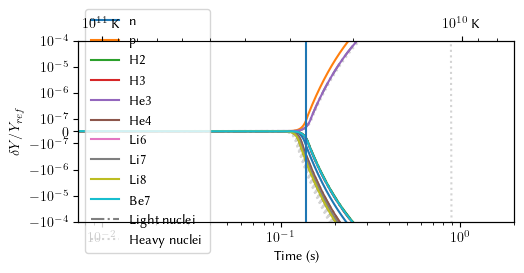

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(width, 2.5))

#fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.995, bottom=0.175, top=0.9)
spacing=[1,1,3,3,2,1]

#plt.plot(midtesttimes,[(abun[1]) for abun in midabuns],'-.',color='gray', label='Light nuclei')
stabilitystep=10
for i in range(10,fnNucs):
    plt.plot(nptesttimes,[(abun[i]-npabuns[stabilitystep][i])/npabuns[stabilitystep][i] for abun in npabuns],':',color='lightgray')

for i in range(2,10):
    plt.plot(nptesttimes,[(abun[i]-npabuns[0][i])/npabuns[0][i] for abun in npabuns],'-.',color='gray')


for i in range(10):#,11,12,13,15,16]:
    plt.plot(nptesttimes,[(abun[i]-npabuns[stabilitystep][i])/npabuns[stabilitystep][i] for abun in npabuns],line[i],label=Y_labels[i])
#plt.plot(midtesttimes,[(abun[11]-npabuns[stabilitystep][11])/npabuns[stabilitystep][11] for abun in midabuns],line[11],label=Y_labels[11])
plt.plot(nptesttimes,[(abun[1]) for abun in npabuns],'-.',color='gray', label='Light nuclei')

plt.plot(nptesttimes,[(abun[1]) for abun in npabuns],':',color='lightgray', label='Heavy nuclei')


plt.xlabel('Time (s)')
plt.ylabel(r'$\delta Y/Y_{ref}$')
xlims=(t_ini/timeunit,2)
plt.ylim(-1e-4,1e-4)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.yscale('symlog',linthresh=1.2e-7,linscale=0.5)

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/npnettime.pdf')
plt.axvline(27e9)
plt.show()

#plt.xlim(0.5,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
#plt.yscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
#plt.xlabel('Number of terms')
#plt.ylabel(r'$\delta Y/Y_{ref}$')
#plt.legend(title='T (MeV)',loc='upper right')
#50keV
#fig.savefig('TeX/figures/Besselaccuracy.pdf')

In [18]:
Li6[-1]/Li6[0]-1

-0.00011290715377709759

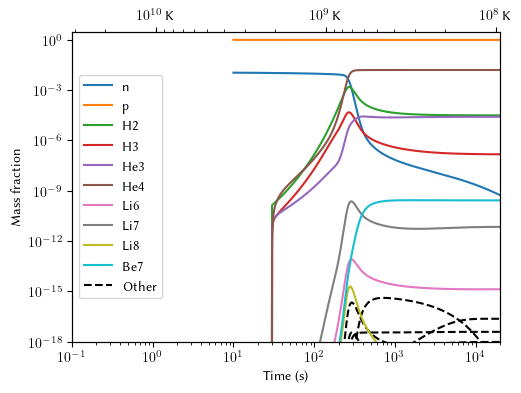

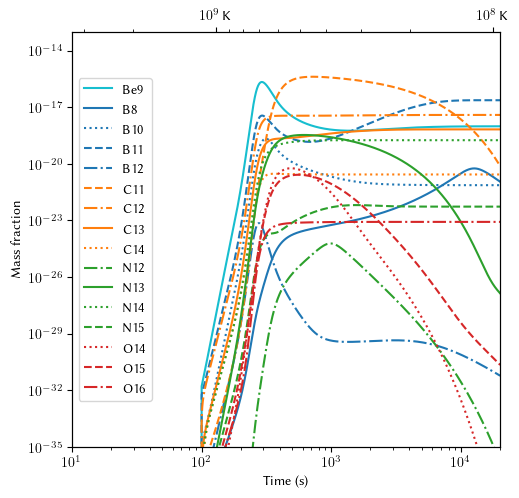

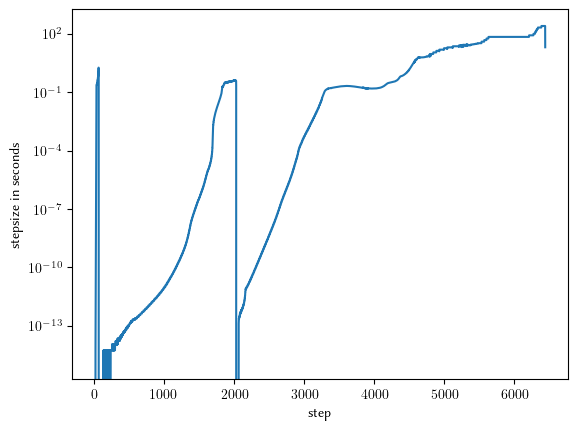

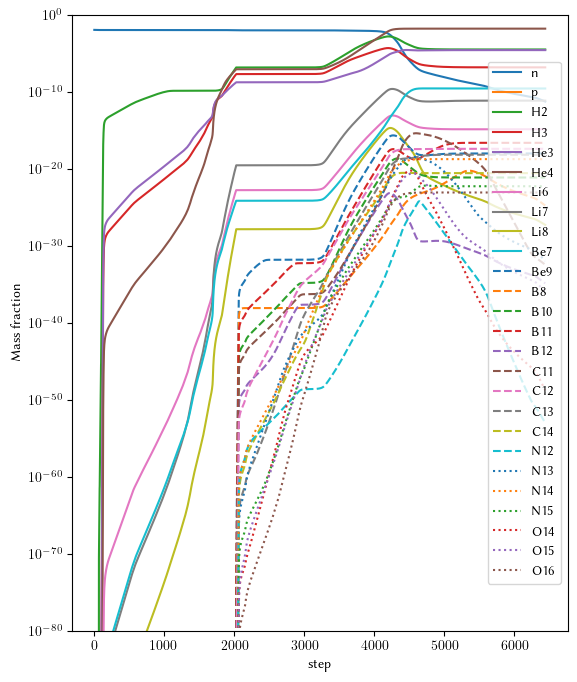

In [19]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]


#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'k--')
for i in range(10):
    plt.plot(soltime/timeunit, A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])
plt.plot(soltime/timeunit, A[19]*solY[19],'k--', label='Other')

#plt.axvline(soltime[1150]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
xlims=(0.1,2e4)
plt.ylim(1e-18,3)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
plt.ylim(1e-35,1e-13)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()

######

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range(len(soltime))] )

plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
plt.show()

plt.figure('abundance',figsize=(6.4, 8))

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

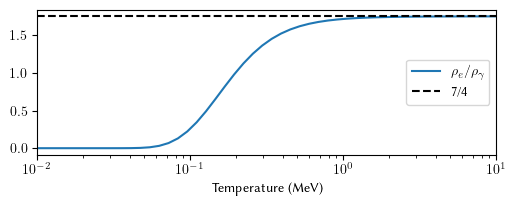

In [20]:
def Testrho_e(T,i): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,i)])




T_test=np.logspace(-2,1)

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 2))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)
plt.plot(T_test,np.array([rho_e(T) for T in T_test])/np.array([rho_gamma(T) for T in T_test]),label=r'$\rho_{e}/\rho_{\gamma}$')
#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
plt.xscale('log')
plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(0.01,10)
#plt.axvline(T_ini)
#plt.yscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-40,1e2)#
plt.xlabel('Temperature (MeV)')
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')
plt.legend(loc='right')
#50keV
#fig.savefig('TeX/figures/rhoegammaT.pdf')

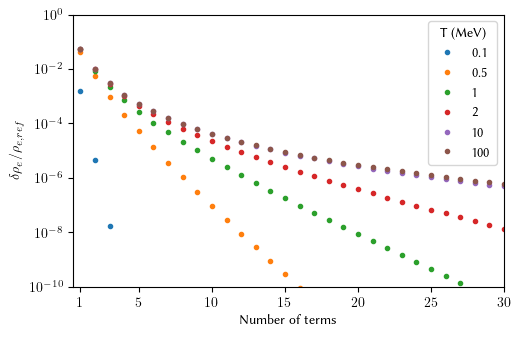

In [21]:
def Testrho_e(T,i): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,i+1)])

fig, axes = plt.subplots(1, 1, figsize=(width, 3.3))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.13, right=0.975, bottom=0.125, top=0.95)
spacing=[1,1,3,3,2,1]
for j,T in enumerate([0.1,0.5,1,2,10,100]):
    plt.plot(range(1,31),[abs((Testrho_e(T,1000)-Testrho_e(T,i))/Testrho_e(T,1000)) for i in range(1,31)],'.',label=str(T))
plt.plot()

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(0.5,30)
plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('log')
#plt.formatter.use_mathtext=True
plt.ylim(1e-10,1)#
plt.xlabel('Number of terms')
plt.ylabel(r'$\delta\rho_{e}/\rho_{e,ref}$')
plt.legend(title='T (MeV)',loc='upper right')
#50keV
#fig.savefig('TeX/figures/Besselaccuracy.pdf')

In [22]:
5*'\t'

'\t\t\t\t\t'

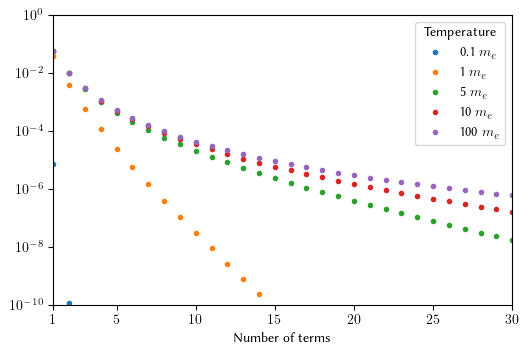

In [23]:
def TestP_e(T,i): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,i+1)])

T_test=np.logspace(-2,1) 

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for T in [0.1,1,5,10,100]:
    plt.plot(range(1,31),[abs((TestP_e(T*e_mass,1000)-TestP_e(T*e_mass,i))/TestP_e(T*e_mass,1000)) for i in range(1,31)],'.',label=str(T)+' '+r'$ m_e$')
plt.plot()

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(1,30)
plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('log')
#plt.formatter.use_mathtext=True
plt.ylim(1e-10,1)#
plt.xlabel('Number of terms')
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')
plt.legend(title='Temperature')#(loc='right')
#50keV
#fig.savefig('TeX/figures/rhoegammaT.pdf')

In [24]:
range(5,30,5)

range(5, 30, 5)

In [25]:
list(range(1,31))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [26]:
e_mass*100

51.099895